# The AR6 Shared Socioeconomic Pathway Effective Radiative Forcing Timeseries, 1750-2500

In [1]:
import numpy as np
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats
import random
import pandas as pd
from tqdm import tqdm_notebook
import random
import os

from ar6.utils import weighted_percentile, check_and_download
from ar6.utils.h5 import *

import matplotlib.pyplot as pl
%matplotlib inline

import urllib.request

In [2]:
forcing = {}

check_and_download(
    '../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv',
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv'
)

check_and_download(
    '../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv',
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-concentrations-annual-means-v5-1-0.csv'
)
    
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
concentrations = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')

In [3]:
scenarios = ['ssp119','ssp126','ssp245','ssp370','ssp370-lowNTCF-gidden','ssp370-lowNTCF-aerchemmip','ssp434','ssp460','ssp534-over','ssp585']
for scenario in scenarios:
    forcing[scenario] = {}

## Solar radiation
ERF = TSI * 1/4 * 0.71 * 0.72 where 1/4 is geometric factor, 0.71 is planetary co-albedo, 0.72 is rapid adjustment factor

We rebase to the two solar cycles 1745-1765 as our estimate of "pre-industrial". This follows AR5 and is a period of somewhat lower solar activity than 1850-1873 used for CMIP6 pre-industrial.

In [4]:
# get solar forcing from CMIP6 TSI time series
df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
solar_erf = np.zeros((751))
solar_erf[:550] = df.solar_erf.loc[1750:2299].values
for scenario in scenarios:
    forcing[scenario]['solar']=solar_erf

## Volcanic forcing

Use the stratospheric optical depth time series from a combination of Toohey and Sigl (2017; -500 to 1900) and CMIP6 (1850-2014). **DIFFERENCE TO AR6 TIMESERIES** we ramp down to zero over 10 years from 2014, which differs from AR6 where we use Glossac

ERF = -20 * SAOD based on a combination of CMIP5 models (Larson and Portmann, 2016) and CMIP6 models (my analysis)

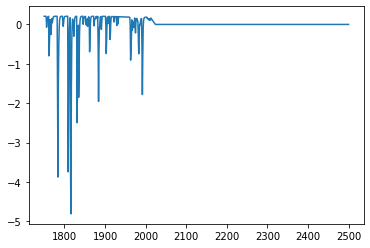

In [6]:
df = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
volcanic_erf = np.zeros((751))
volcanic_erf[:265] = df.volcanic_erf.loc[1750:2014].values
# ramp down last 10 years to zero according to https://www.geosci-model-dev.net/9/3461/2016/gmd-9-3461-2016.html
volcanic_erf[264:275] = volcanic_erf[264] * np.linspace(1,0,11)
volcanic_erf[275:] = 0.
pl.plot(np.arange(1750,2501), volcanic_erf[:])
#emissions = np.loadtxt('../data/SSP460_INTERIM_EMISSIONS.csv', skiprows=3, delimiter=',')

for scenario in scenarios:
    forcing[scenario]['volcanic']=volcanic_erf

## Aerosol forcing
Use a combination of the model-derived time series from Smith et al. (2020; JGRA; submitted) and the analysis of MERRA2 and CAMS reanalysis from Bellouin et al. (2020; ESSD).

The target forcings are -0.3 W/m2 for ERFari 2005-14 and -1.0 for ERFaci 2005-14.

- 1750 - 1979: Smith et al. only
- 1980 - 2002: mean of Smith et al. and MERRA2
- 2003 - 2014: weighted mean of Smith et al. (0.5), MERRA2 (0.25) and CAMS (0.25)

- **TODO: update this with Nicolas' actual figures rather than my graph-derived ones**
- **TODO: put Smith et al 2020 code on the repository and generate coefficients**

The target forcings are -0.3 W/m2 for ERFari 2005-14 and -1.0 for ERFaci 2005-14.

In [10]:
#check_and_download(
#    '../data_input_large/ERFari.h5',
#    'https://zenodo.org/record/4114420/files/ERFaci.h5'
#)
#
#check_and_download(
#    '../data_input_large/ERFaci.h5',
#    'https://zenodo.org/record/4114420/files/ERFaci.h5',#?versionId=f734d2f4-1042-458d-922e-67bd69bd7e63'
#)

check_and_download(
    '../data_input_large/knutti_score.h5',
    'https://zenodo.org/record/4114420/files/knutti_score.h5',#?versionId=43f3a668-82dc-4d7b-92b9-e994b10134e4'
)

In [14]:
def aerocom(x, bc, oc, so2):
    return bc*x[0] + oc*x[1] + so2*x[2]

def ghan(x, beta, n0, n1):
    return -beta*np.log(1 + x[0]/n0 + x[1]/n1)

df = pd.read_csv('../data_input/Bellouin_MERRA2.csv', index_col=0)
merra_ari = df['RFari'].values * (-0.3)/df['RFari'].values[25:35].mean()
merra_aci = df['RFaci'].values * (-1.0)/df['RFaci'].values[25:35].mean()

df = pd.read_csv('../data_input/Bellouin_CAMS.csv', index_col=0)
cams_ari = df['RFari'].values * (-0.3)/df['RFari'].values[2:12].mean()
cams_aci = df['RFaci'].values * (-1.0)/df['RFaci'].values[2:12].mean()

samples = 25000

In [15]:
# Use Nicolas' Ringberg methods, from script provided to me
def uniform1684(a,b,seed,samples=2000):
    interval = (b-a)+((b-a)/(84-16)*32)
    lower = a-((b-a)/(84-16)*16)
    return scipy.stats.uniform.rvs(lower, interval, size=samples, random_state=seed)
#samples=500
dtau    = uniform1684(0.02,0.04,123,samples=samples)
tau     = uniform1684(0.13,0.17,124,samples=samples)
S_tau   = uniform1684(-27,-20,125,samples=samples)
RFari_cloudy = uniform1684(-0.1,0.1,126,samples=samples)
dR_dRatm = uniform1684(-0.3,-0.1,127,samples=samples)
dRatm_dtau = uniform1684(17,35,128,samples=samples)
c_tau    = uniform1684(0.59,0.71,129,samples=samples)
c_N      = uniform1684(0.19,0.29,130,samples=samples)
c_L      = uniform1684(0.21,0.29,131,samples=samples)
c_C      = uniform1684(0.59,1.07,132,samples=samples)
beta_N_tau = uniform1684(0.3,0.8,133,samples=samples)
beta_L_N   = uniform1684(-0.36,-0.011,134,samples=samples)
beta_C_N   = uniform1684(0,0.1,135,samples=samples)
S_N = uniform1684(-27,-26,136,samples=samples)
S_L = uniform1684(-56,-54,137,samples=samples)
S_C = uniform1684(-153,-91,138,samples=samples)

rfari = dtau*S_tau*(1-c_tau)+RFari_cloudy
rfari_adj = dtau*dR_dRatm*dRatm_dtau

dlntau = dtau/tau
deltan = dlntau * beta_N_tau

rfaci = dlntau*beta_N_tau*S_N*c_N
erfaci_L = dlntau*beta_N_tau*beta_L_N*S_L*c_L
erfaci_C = dlntau*beta_N_tau*beta_C_N*S_C*c_C

ERFari_scale = rfari + rfari_adj
ERFaci_scale = rfaci + erfaci_L + erfaci_C

In [10]:
ERFari = {}
ERFaci = {}
for scenario in tqdm_notebook(scenarios):
    #print(scenario)
    ERFari[scenario] = np.zeros((751,samples))
    ERFaci[scenario] = np.zeros((751,samples))
    bc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    oc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|OC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    so2 = molwt.S/molwt.SO2*emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|Sulfur'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    for i in range(samples):
        ts2010 = np.mean(aerocom([bc[255:265], oc[255:265], so2[255:265]], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0]))
        ts1850 = aerocom([bc[100], oc[100], so2[100]], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
        ts1750 = aerocom([bc[0], oc[0], so2[0]], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
        ERFari[scenario][:,i] = (
            aerocom([bc, oc, so2], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0]) - ts1750
        )/(ts2010-ts1850)*ERFari_scale[i]
        ts2010 = np.mean(ghan([so2[255:265], oc[255:265]+bc[255:265]], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]))
        ts1850 = ghan([so2[100], oc[100]+bc[100]], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
        ts1750 = ghan([so2[0], oc[0]+bc[0]], 0.97, aci_coeffs[i,0], aci_coeffs[i,1])  
        ERFaci[scenario][:,i] = (
            ghan([so2, oc+bc], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
        - ts1750
        )/(ts2010-ts1850)*(ERFaci_scale[i])

/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# scale up to the assessment
ERFari_unscaled = np.sum(ERFari[scenario]*ks['multi']['CMIP6-constrained'], axis=1)
ERFaci_unscaled = np.sum(ERFaci[scenario]*ks['multi']['CMIP6-constrained'], axis=1)
rebase_ari = -0.3/np.mean(ERFari_unscaled[255:265])
rebase_aci = -1.0/np.mean(ERFaci_unscaled[255:265])
for scenario in scenarios:
    ERFari[scenario] = ERFari[scenario] * rebase_ari
    ERFaci[scenario] = ERFaci[scenario] * rebase_aci

In [12]:
for scenario in tqdm_notebook(scenarios):
    forcing[scenario]['aerosol-radiation_interactions'] = np.sum(ERFari[scenario]*ks['multi']['CMIP6-constrained'], axis=1)
    forcing[scenario]['aerosol-radiation_interactions'][230:253] = np.mean((np.sum(ERFari[scenario]*ks['multi']['CMIP6-constrained'], axis=1)[230:253], merra_ari[:23]), axis=0)
    forcing[scenario]['aerosol-radiation_interactions'][253:265] = np.mean((np.sum(ERFari[scenario]*ks['multi']['CMIP6-constrained'], axis=1)[253:265], np.mean((merra_ari[23:35], cams_ari[:12]), axis=0)), axis=0)
    forcing[scenario]['aerosol-cloud_interactions'] = np.sum(ERFaci[scenario]*ks['multi']['CMIP6-constrained'], axis=1)
    forcing[scenario]['aerosol-cloud_interactions'][230:253] = np.mean((np.sum(ERFaci[scenario]*ks['multi']['CMIP6-constrained'], axis=1)[230:253], merra_aci[:23]), axis=0)
    forcing[scenario]['aerosol-cloud_interactions'][253:265] = np.mean((np.sum(ERFaci[scenario]*ks['multi']['CMIP6-constrained'], axis=1)[253:265], np.mean((merra_aci[23:35], cams_aci[:12]), axis=0)), axis=0)


/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


## BC on snow

Linear with emissions, 2019 = 0.08

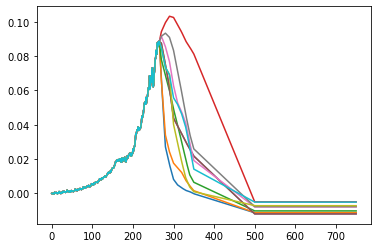

In [13]:
bc2019 = emissions.loc[(emissions['Scenario']=='ssp245')&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()[269]
for scenario in scenarios:
    bc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    forcing[scenario]['bc_on_snow'] = (bc-bc[0])/(bc2019-bc[0])*0.08
    pl.plot(forcing[scenario]['bc_on_snow'])

## Contrail forcing

Based on Lee et al 2018 forcing of 0.0574 and scales with aviation NOx emissions. 

**TODO update chapter for 2019 forcing**

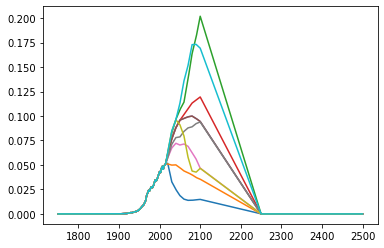

In [14]:
df = pd.read_csv('/nfs/a65/pmcjs/input4MIPs/SSPDb/aviation_nox.csv')
for scenario in scenarios:
    avi_nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    avi_nox_ssp245 = emissions.loc[(emissions['Scenario']=='ssp245')&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    contrail_forcing_2018 = 0.0574
    forcing[scenario]['contrails'] = avi_nox/avi_nox_ssp245[268] * contrail_forcing_2018
    pl.plot(np.arange(1750,2501), forcing[scenario]['contrails'])

## Land use forcing

Use Ghimire et al. 2014 up to 2005, then FaIR cumulative emissions to 2019, scale to 0.15 W/m2 for 1750 to 2019, and then add --0.05 for irrigation

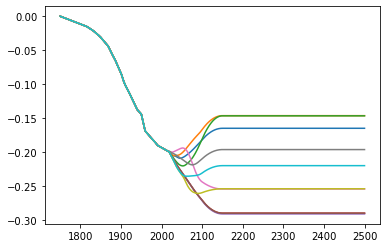

In [15]:
ghimire = pd.read_csv('../data/ghimire_landuse_raw.csv')
for scenario in scenarios:
    lusf2019 = -0.20/np.cumsum(emissions.loc[(emissions['Scenario']=='ssp245')&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2020'].interpolate(axis=1, pad=True).values.squeeze())[269]  # include irrigation of -0.05 in Sherwood et al
    forcing[scenario]['land_use'] = np.cumsum(emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze())*lusf2019
    f = interp1d(ghimire['year'], ghimire['flux'], kind='linear', fill_value='extrapolate', bounds_error=False)
    lusf2019 = -0.20/(f(2019)-f(1750))
    forcing[scenario]['land_use'][:269] = lusf2019*(f(np.arange(1750,2019))-f(1750))
    pl.plot(np.arange(1750, 2501), forcing[scenario]['land_use'])

## Greenhouse gas concentrations

For consistency I will use the observations for GHGs to 2019, and then ramp to SSPs in 2029.

**TODO** what are we doing about +5% in non-CO2 gases?

**TODO** use Meinshausen forcing relationship?

In [16]:
ghg_obs = pd.read_excel('../data/LLGHG_history_AR6_v8a.xlsx', skiprows=22, sheet_name="MR_output", index_col=0)
for addyear in range(1751,1850):
    ghg_obs.loc[addyear, 'YYYY'] = np.nan
ghg_obs = ghg_obs.sort_index()
ghg_obs = ghg_obs.interpolate()
gases_obs = ghg_obs.columns.to_list()
gases_obs.remove('YYYY')
print(*(gases_obs))

gases=['CO2','CH4','N2O',
     'HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
     'NF3','C2F6','C3F8','C4F10','C5F12','C6F14','C7F16','C8F18','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
     'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
     'Halon1301','Halon2402']

CO2 CH4 N2O HFC-134a HFC-23 HFC-32 HFC-125 HFC-143a HFC-152a HFC-227ea HFC-236fa HFC-245fa HFC-365mfc HFC-43-10mee NF3 SF6 SO2F2 CF4 C2F6 C3F8 c-C4F8 CFC-12 CFC-11 CFC-113 CFC-114 CFC-115 CFC-13 HCFC-22 HCFC-141b HCFC-142b CH3CCl3 CCl4 CH3Cl CH3Br CH2Cl2 CHCl3 Halon-1211 Halon-1301 Halon-2402 n-C4F10 n-C5F12 n-C6F14 i-C6F14 C7F16 C8F18 CFC-112 CFC-112a CFC-113a CFC-114a HCFC-133a HCFC-31 HCFC-124


/nfs/b0110/Users/mencsm/miniconda3/envs/aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


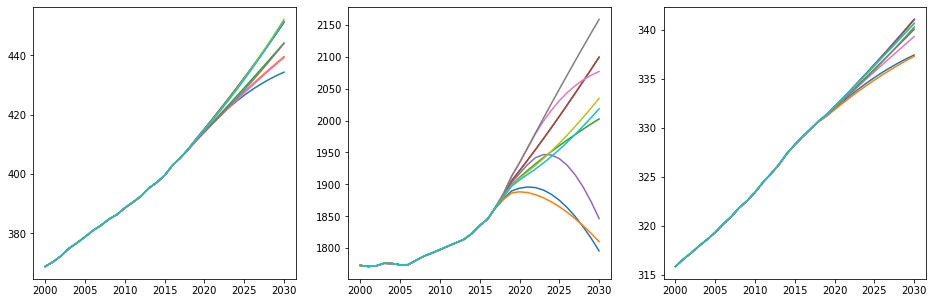

In [17]:
fig, ax = pl.subplots(1,3,figsize=(16,5))
for scenario in tqdm_notebook(scenarios):
    forcing[scenario]['co2'] = np.zeros(751)
    forcing[scenario]['ch4'] = np.zeros(751)
    forcing[scenario]['n2o'] = np.zeros(751)

    co2 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CO2')),'1750':'2500'].values.squeeze()
    ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
    n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1750':'2500'].values.squeeze()
    co2[:265] = ghg_obs['CO2'].values[:265]
    ch4[:265] = ghg_obs['CH4'].values[:265]
    n2o[:265] = ghg_obs['N2O'].values[:265]
    
    co2[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CO2'].values[264:270] + np.linspace(0,1,6) * co2[264:270]
    ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
    n2o[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['N2O'].values[264:270] + np.linspace(0,1,6) * n2o[264:270]
    
    for i, year in enumerate(range(1750,2501)):
        forcing[scenario]['co2'][i], forcing[scenario]['ch4'][i], forcing[scenario]['n2o'][i] = meinshausen( #etminan(
            [co2[i], ch4[i], n2o[i]], 
            [co2[0], ch4[0], n2o[0]], scale_F2x=False)

    # include rapid adjustments for CO2 and CH4 (FOD numbers):
    forcing[scenario]['co2'] = 1.05 * forcing[scenario]['co2']
    forcing[scenario]['ch4'] = 0.86 * forcing[scenario]['ch4']
    
    ax[0].plot(np.arange(2000,2031), co2[250:281])
    ax[1].plot(np.arange(2000,2031),ch4[250:281])
    ax[2].plot(np.arange(2000,2031),n2o[250:281])

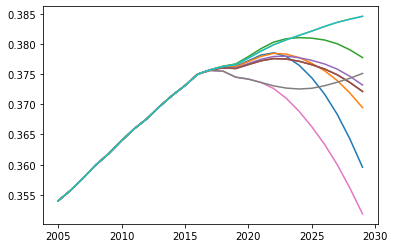

In [18]:
gases=['CO2','CH4','N2O',
     'HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
     'NF3','C2F6','C3F8','C4F10','C5F12','C6F14','C7F16','C8F18','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
     'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
     'Halon1301','Halon2402']

radeff = {
    'HFC-125':      0.23378,
    'HFC-134a':     0.16714,
    'HFC-143a':     0.168,
    'HFC-152a':     0.10174,
    'HFC-227ea':    0.27325,
    'HFC-23':       0.19111,
    'HFC-236fa':    0.25069,
    'HFC-245fa':    0.24498,
    'HFC-32':       0.11144,
    'HFC-365mfc':   0.22813,
    'HFC-43-10mee': 0.35731,
    'NF3':          0.20448,
    'C2F6':         0.26105,
    'C3F8':         0.26999,
    'n-C4F10':      0.36874,
    'n-C5F12':      0.4076,
    'n-C6F14':      0.44888,
    'i-C6F14':      0.44888, # not given in Hodnebrog: assume same as n-form
    'C7F16':        0.50312,
    'C8F18':        0.55787,
    'CF4':          0.09859,
    'c-C4F8':       0.31392,
    'SF6':          0.56657,
    'SO2F2':        0.21074,
    'CCl4':         0.16616,
    'CFC-11':       0.25941,
    'CFC-112':      0.28192,  # Etminan et al., 2014 https://core.ac.uk/download/pdf/29111788.pdf
    'CFC-112a':     0.24564,  # Etminan et al., 2014 https://core.ac.uk/download/pdf/29111788.pdf - assume same as 112
    'CFC-113':      0.30142,
    'CFC-113a':     0.24094,  # Etminan et al., 2014
    'CFC-114':      0.31433,
    'CFC-114a':     0.29747, # assume same as 114 - does this make sense?
    'CFC-115':      0.24625,
    'CFC-12':       0.31998,
    'CFC-13':       0.27752,
    'CH2Cl2':       0.02882,
    'CH3Br':        0.00432,
    'CH3CCl3':      0.06454,
    'CH3Cl':        0.00466,
    'CHCl3':        0.07357,
    'HCFC-124':     0.20721,
    'HCFC-133a':    0.14995,
    'HCFC-141b':    0.16065,
    'HCFC-142b':    0.19329,
    'HCFC-22':      0.21385,
    'HCFC-31':      0.068,
    'Halon-1211':   0.30014,
    'Halon-1301':   0.29943,
    'Halon-2402':   0.31169,
}

meins_names={
    'HFC-125':      'HFC125',
    'HFC-134a':     'HFC134a',
    'HFC-143a':     'HFC143a',
    'HFC-152a':     'HFC152a',
    'HFC-227ea':    'HFC227ea',
    'HFC-23':       'HFC23',
    'HFC-236fa':    'HFC236fa',
    'HFC-245fa':    'HFC245fa',
    'HFC-32':       'HFC32',
    'HFC-365mfc':   'HFC365mfc',
    'HFC-43-10mee': 'HFC4310mee',
    'NF3':          'NF3',
    'C2F6':         'C2F6',
    'C3F8':         'C3F8',
    'n-C4F10':      'C4F10',
    'n-C5F12':      'C5F12',
    'n-C6F14':      'C6F14',
    'i-C6F14':      None,
    'C7F16':        'C7F16',
    'C8F18':        'C8F18',
    'CF4':          'CF4',
    'c-C4F8':       'cC4F8',
    'SF6':          'SF6',
    'SO2F2':        'SO2F2',
    'CCl4':         'CCl4',
    'CFC-11':       'CFC11',
    'CFC-112':      'CFC112',  # Etminan et al., 2014 https://core.ac.uk/download/pdf/29111788.pdf
    'CFC-112a':     None,  # Etminan et al., 2014 https://core.ac.uk/download/pdf/29111788.pdf - assume same as 112
    'CFC-113':      'CFC113',
    'CFC-113a':     None,  # Etminan et al., 2014
    'CFC-114':      'CFC114',
    'CFC-114a':     None, # assume same as 114 - does this make sense?
    'CFC-115':      'CFC115',
    'CFC-12':       'CFC12',
    'CFC-13':       None,
    'CH2Cl2':       'CH2Cl2',
    'CH3Br':        'CH3Br',
    'CH3CCl3':      'CH3CCl3',
    'CH3Cl':        'CH3Cl',
    'CHCl3':        'CHCl3',
    'HCFC-124':     None,
    'HCFC-133a':    None,
    'HCFC-141b':    'HCFC141b',
    'HCFC-142b':    'HCFC142b',
    'HCFC-22':      'HCFC22',
    'HCFC-31':      None,
    'Halon-1211':   'Halon1211',
    'Halon-1301':   'Halon1301',
    'Halon-2402':   'Halon2402',
}

for scenario in scenarios:
    forcing[scenario]['other_wmghg'] = np.zeros(751)
    for gas in gases_obs[3:]:
        #print(concentrations.loc[(concentrations['Scenario']=='ssp245')&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith(gas)),'1750':'2500'].values.squeeze())
        #for i,year in enumerate(range(1750,2501)):
        #    print(concentrations.loc[(concentrations['Scenario']=='ssp245')&(concentrations['Region']=='World')&(concentrations['Variable']=='Atmospheric Concentrations|%s' % gas),'%s' % year])
        meins = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith(meins_names[gas])),'1750':'2500'].values.squeeze()
        if meins.shape == (0,751):
            meins = np.zeros(751)
        obs = ghg_obs[gas].values[:270]
        conc = np.zeros(751)
        conc[:265] = obs[:265]
        conc[264:270] = np.linspace(1.0,0.0,6) * obs[264:270] + np.linspace(0,1,6) * meins[264:270]
        conc[270:] = meins[270:]
        forcing[scenario]['other_wmghg'] = forcing[scenario]['other_wmghg'] + ((conc - conc[0]) * radeff[gas] * 0.001)
    pl.plot(np.arange(2005,2030), forcing[scenario]['other_wmghg'][255:280])

## Tropospheric ozone

Follow Skeie (AR6) for 1750-2014, then use emissions-based relationships based on Stevenson et al. **TODO** coefficients from AerChemMIP

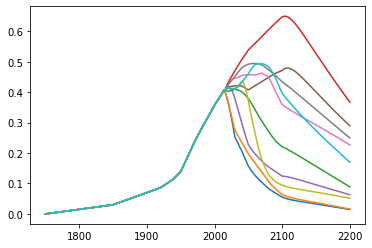

In [19]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_trop = pd.read_csv('../data/skeie_ozone_trop.csv', index_col=0)
skeie_trop = skeie_trop.loc[good_models]
skeie_trop.insert(0, 1850, 0)
skeie_trop.columns = pd.to_numeric(skeie_trop.columns)
skeie_trop.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_trop.insert(0, 1750, -0.03)
skeie_trop_post2010 = skeie_trop.loc['OsloCTM3',[2014,2017,2020]]-skeie_trop.loc['OsloCTM3', 2010]
skeie_trop.loc[:,[2014,2017,2020]] = skeie_trop.loc[:,2010:2010].values + skeie_trop_post2010.values[None,:]
skeie_trop = skeie_trop + 0.03
f = interp1d(skeie_trop.columns, skeie_trop.mean(), bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2020)
o3tr = f(years)

for scenario in scenarios:
    co = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|VOC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    voc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations['Variable']=='Atmospheric Concentrations|CH4'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()

    delta_Eco = co[255:265].mean() - co[100:109].mean()
    delta_Enox = nox[255:265].mean() - nox[100:109].mean()
    delta_Evoc = voc[255:265].mean() - voc[100:109].mean()
    delta_Cch4 = ch4[255:265].mean() - ch4[100:109].mean()

    # radiative efficiencies in W/m2/Mt - numbers for W/m2 from Stevenson
    radeff_ch4 = 0.166/delta_Cch4
    radeff_co  = 0.055/delta_Eco
    radeff_nox = 0.119/delta_Enox
    radeff_voc = 0.035/delta_Evoc

    fac_cmip6_skeie = (
        (
        radeff_ch4 * delta_Cch4 +
        radeff_co  * delta_Eco +
        radeff_nox * delta_Enox +
        radeff_voc * delta_Evoc
        ) / (o3tr[260]-o3tr[100])
    )
    ts = np.vstack((ch4, co, nox, voc)).T

    def fit_stevenson(x, rch4, rco, rnox, rvoc):
        return rch4*x[0] + rco*x[1] + rnox*x[2] + rvoc*x[3]

    p, cov = curve_fit(
        fit_stevenson, 
        ts[100:261,:].T - ts[100:261, :].T,
        o3tr[100:261],
        bounds=((0.120/delta_Cch4/fac_cmip6_skeie, 0.045/delta_Eco/fac_cmip6_skeie, 0.086/delta_Enox/fac_cmip6_skeie, 0.035/delta_Evoc/fac_cmip6_skeie),
                (0.212/delta_Cch4/fac_cmip6_skeie, 0.071/delta_Eco/fac_cmip6_skeie, 0.152/delta_Enox/fac_cmip6_skeie, 0.053/delta_Evoc/fac_cmip6_skeie))
    )

    forcing[scenario]['o3_tropospheric'] = np.zeros((751))
    forcing[scenario]['o3_tropospheric'][:265] = o3tr[:265]
    forcing[scenario]['o3_tropospheric'][265:] = (
        p[0] * (ch4[265:] - ch4[0]) +
        p[1] * (co[265:]  - co[0]) +
        p[2] * (nox[265:]  - nox[0])+
        p[3] * (voc[265:]  - voc[0])
    )# + o3tr[264]

    pl.plot(np.arange(1750,2201), forcing[scenario]['o3_tropospheric'][:451])

## Stratospheric ozone

I ain't got no clud what to do here.

Follow Skeie (AR6) for 1750-2014, then use emissions-based relationships based on Stevenson et al. **TODO** coefficients from AerChemMIP **for the positive component**

In the Skeie models, it looks like negative forcing from ODSs has recovered to zero - so assume no future dependence on EESC.

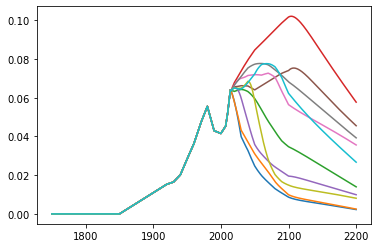

In [20]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_strat = pd.read_csv('../data/skeie_ozone_strat.csv', index_col=0)
skeie_strat = skeie_strat.loc[good_models]
skeie_strat.insert(0, 1850, 0)
skeie_strat.columns = pd.to_numeric(skeie_strat.columns)
skeie_strat.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_strat.insert(0, 1750, 0)
skeie_strat_post2010 = skeie_strat.loc['OsloCTM3',[2014,2017,2020]]-skeie_strat.loc['OsloCTM3', 2010]
skeie_strat.loc[:,[2014,2017,2020]] = skeie_strat.loc[:,2010:2010].values + skeie_strat_post2010.values[None,:]
f = interp1d(skeie_strat.columns, skeie_strat.mean(), bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2020)
o3st = f(years)

for scenario in scenarios:
    co = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|VOC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    voc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations['Variable']=='Atmospheric Concentrations|CH4'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()

    delta_Eco = co[255:265].mean() - co[100:109].mean()
    delta_Enox = nox[255:265].mean() - nox[100:109].mean()
    delta_Evoc = voc[255:265].mean() - voc[100:109].mean()
    delta_Cch4 = ch4[255:265].mean() - ch4[100:109].mean()

    # radiative efficiencies in W/m2/Mt - numbers for W/m2 from Stevenson
    radeff_ch4 = 0.166/delta_Cch4
    radeff_co  = 0.055/delta_Eco
    radeff_nox = 0.119/delta_Enox
    radeff_voc = 0.035/delta_Evoc

    fac_cmip6_skeie = (
        (
        radeff_ch4 * delta_Cch4 +
        radeff_co  * delta_Eco +
        radeff_nox * delta_Enox +
        radeff_voc * delta_Evoc
        ) / (o3tr[260]-o3tr[100])
    )
    ts = np.vstack((ch4, co, nox, voc)).T

    def fit_stevenson(x, rch4, rco, rnox, rvoc):
        return rch4*x[0] + rco*x[1] + rnox*x[2] + rvoc*x[3]

    p, cov = curve_fit(
        fit_stevenson, 
        ts[100:261,:].T - ts[100:261, :].T,
        o3tr[100:261],
        bounds=((0.120/delta_Cch4/fac_cmip6_skeie, 0.045/delta_Eco/fac_cmip6_skeie, 0.086/delta_Enox/fac_cmip6_skeie, 0.035/delta_Evoc/fac_cmip6_skeie),
                (0.212/delta_Cch4/fac_cmip6_skeie, 0.071/delta_Eco/fac_cmip6_skeie, 0.152/delta_Enox/fac_cmip6_skeie, 0.053/delta_Evoc/fac_cmip6_skeie))
    )

    forcing[scenario]['o3_stratospheric'] = np.zeros((751))
    forcing[scenario]['o3_stratospheric'][:265] = o3st[:265]
    forcing[scenario]['o3_stratospheric'][265:] = skeie_strat.mean()[2014]/skeie_trop.mean()[2014]*(
        p[0] * (ch4[265:] - ch4[0]) +
        p[1] * (co[265:]  - co[0]) +
        p[2] * (nox[265:]  - nox[0])+
        p[3] * (voc[265:]  - voc[0])
    )# + o3tr[264]

    pl.plot(np.arange(1750,2201), forcing[scenario]['o3_stratospheric'][:451])

## Stratospheric water vapour

In [21]:
for scenario in scenarios:
    forcing[scenario]['h2o_stratospheric'] = forcing[scenario]['ch4']/forcing[scenario]['ch4'][269] * 0.05

In [22]:
colors = {
    'ssp119': '#1e9583',
    'ssp126': '#1d3354',
    'ssp245': '#e9dc3d',  # WHY is ssp245 yellow? This infuriates me
    'ssp370': '#f11111',
    'ssp370-lowNTCF-gidden': '#f11111', 
    'ssp370-lowNTCF-aerchemmip': '#f11111',
    'ssp434': '#63bce4',
    'ssp460': '#e78731',
    'ssp534-over': '#996dc8',
    'ssp585': '#830b22',
}

ls = {
    'ssp119': '-',
    'ssp126': '-',
    'ssp245': '-', 
    'ssp370': '-',
    'ssp370-lowNTCF-gidden': '--', 
    'ssp370-lowNTCF-aerchemmip': '-.',
    'ssp434': '-',
    'ssp460': '-',
    'ssp534-over': '-',
    'ssp585': '-',
}

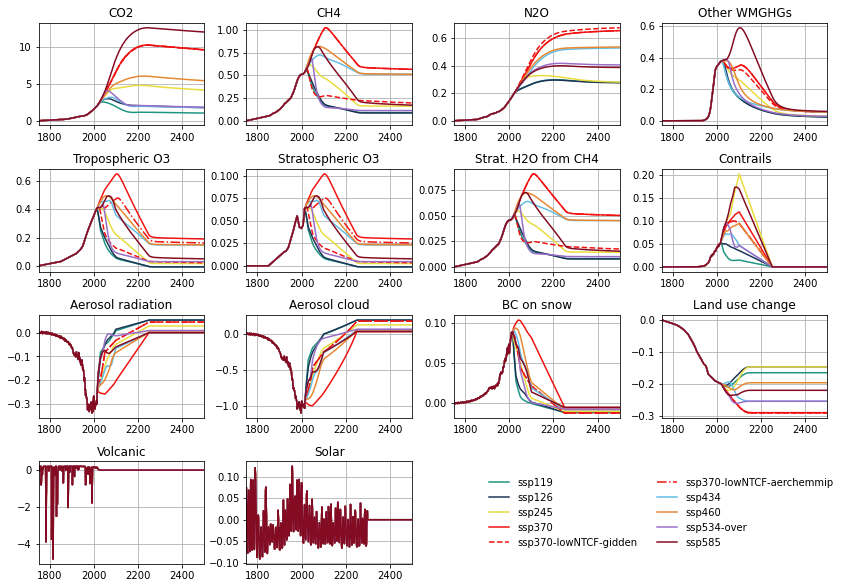

In [23]:
# solar forcing will use the averages of the solar cycles from 1745 to 1765 as the baseline: this is a different treatment to CMIP6
fig, ax = pl.subplots(4,4, figsize=(29.7/2.54,21/2.54),squeeze=True)
for scenario in scenarios:
    ax[0,0].plot(np.arange(1750,2501),forcing[scenario]['co2'], color=colors[scenario], ls=ls[scenario])
    ax[0,1].plot(np.arange(1750,2501),forcing[scenario]['ch4'], color=colors[scenario], ls=ls[scenario])
    ax[0,2].plot(np.arange(1750,2501),forcing[scenario]['n2o'], color=colors[scenario], ls=ls[scenario])
    ax[0,3].plot(np.arange(1750,2501),forcing[scenario]['other_wmghg'], color=colors[scenario], ls=ls[scenario])
    ax[1,0].plot(np.arange(1750,2501),forcing[scenario]['o3_tropospheric'], color=colors[scenario], ls=ls[scenario])
    ax[1,1].plot(np.arange(1750,2501),forcing[scenario]['o3_stratospheric'], color=colors[scenario], ls=ls[scenario])
    ax[1,2].plot(np.arange(1750,2501),forcing[scenario]['h2o_stratospheric'], color=colors[scenario], ls=ls[scenario])
    ax[1,3].plot(np.arange(1750,2501),forcing[scenario]['contrails'], color=colors[scenario], ls=ls[scenario])
    ax[2,0].plot(np.arange(1750,2501),forcing[scenario]['aerosol-radiation_interactions'], color=colors[scenario], ls=ls[scenario])
    ax[2,1].plot(np.arange(1750,2501),forcing[scenario]['aerosol-cloud_interactions'], color=colors[scenario], ls=ls[scenario])
    ax[2,2].plot(np.arange(1750,2501),forcing[scenario]['bc_on_snow'], color=colors[scenario], ls=ls[scenario])
    ax[2,3].plot(np.arange(1750,2501),forcing[scenario]['land_use'], color=colors[scenario], ls=ls[scenario])
    ax[3,0].plot(np.arange(1750,2501),forcing[scenario]['volcanic'], color=colors[scenario], ls=ls[scenario])
    ax[3,1].plot(np.arange(1750,2501),forcing[scenario]['solar'], color=colors[scenario], ls=ls[scenario], label=scenario)

ax[3,2].axis('off')
ax[3,3].axis('off')
#ax.set_xticks(np.arange(1750,2501,50))
ax[0,0].set_xlim(1750,2500)
ax[0,1].set_xlim(1750,2500)
ax[0,2].set_xlim(1750,2500)
ax[0,3].set_xlim(1750,2500)
ax[1,0].set_xlim(1750,2500)
ax[1,1].set_xlim(1750,2500)
ax[1,2].set_xlim(1750,2500)
ax[1,3].set_xlim(1750,2500)
ax[2,0].set_xlim(1750,2500)
ax[2,1].set_xlim(1750,2500)
ax[2,2].set_xlim(1750,2500)
ax[2,3].set_xlim(1750,2500)
ax[3,0].set_xlim(1750,2500)
ax[3,1].set_xlim(1750,2500)
ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()
ax[0,3].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()
ax[1,3].grid()
ax[2,0].grid()
ax[2,1].grid()
ax[2,2].grid()
ax[2,3].grid()
ax[3,0].grid()
ax[3,1].grid()
ax[0,0].set_title('CO2')
ax[0,1].set_title('CH4')
ax[0,2].set_title('N2O')
ax[0,3].set_title('Other WMGHGs')
ax[1,0].set_title('Tropospheric O3')
ax[1,1].set_title('Stratospheric O3')
ax[1,2].set_title('Strat. H2O from CH4')
ax[1,3].set_title('Contrails')
ax[2,0].set_title('Aerosol radiation')
ax[2,1].set_title('Aerosol cloud')
ax[2,2].set_title('BC on snow')
ax[2,3].set_title('Land use change')
ax[3,0].set_title('Volcanic')
ax[3,1].set_title('Solar')
pl.tight_layout()
ax[3,1].legend(bbox_to_anchor=[3.6,0.5], frameon=False, ncol=2, loc='center right')
pl.savefig('/nfs/see-fs-02_users/mencsm/ssp_erf/components.png')

In [24]:
for scenario in scenarios:
    forcing[scenario]['total_anthropogenic']=forcing[scenario]['co2']+forcing[scenario]['ch4']+forcing[scenario]['n2o']+\
        forcing[scenario]['other_wmghg']+\
        forcing[scenario]['o3_tropospheric']+forcing[scenario]['o3_stratospheric']+forcing[scenario]['h2o_stratospheric']+forcing[scenario]['contrails']+\
        forcing[scenario]['aerosol-radiation_interactions']+forcing[scenario]['aerosol-cloud_interactions']+forcing[scenario]['bc_on_snow']+forcing[scenario]['land_use']
    forcing[scenario]['total_natural']=forcing[scenario]['volcanic']+forcing[scenario]['solar']
    forcing[scenario]['total']=forcing[scenario]['total_anthropogenic']+forcing[scenario]['total_natural']

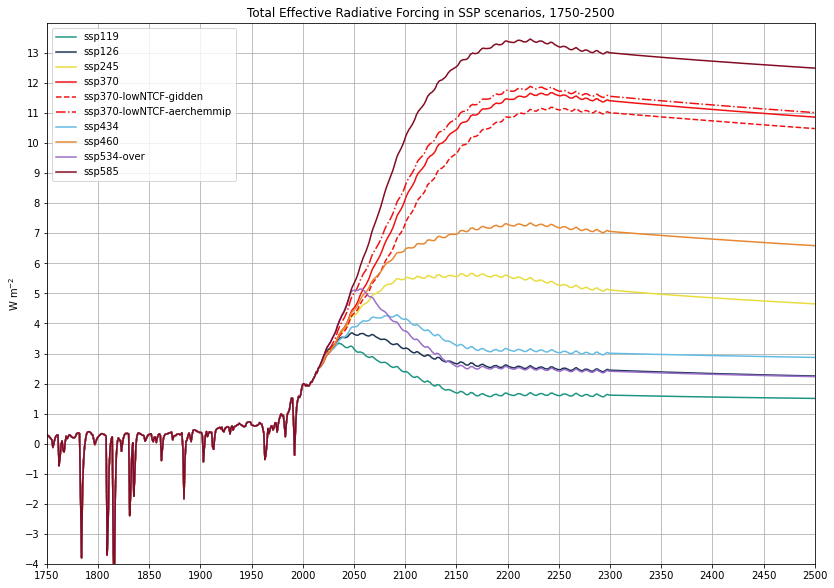

In [25]:
pl.figure(figsize=(29.7/2.54,21/2.54))
for scenario in scenarios:
    pl.plot(np.arange(1750,2501), forcing[scenario]['total'], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.yticks(np.arange(-4,14))
pl.xticks(np.arange(1750,2501,50))
pl.ylim(-4,14)
pl.xlim(1750,2500)
pl.legend()
pl.grid()
pl.title('Total Effective Radiative Forcing in SSP scenarios, 1750-2500')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
pl.savefig('/nfs/see-fs-02_users/mencsm/ssp_erf/total.png')

In [26]:
#forcing['total'][-1]

In [27]:
for scenario in scenarios:
    df = pd.DataFrame(data=forcing[scenario], index=np.arange(1750,2501))
    df.index.name='year'
    df=df[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
      'volcanic','solar','total_anthropogenic','total_natural','total']]
    outname = scenario
    if scenario=='ssp370-lowNTCF':
        outname='ssp370-lowNTCF-gidden'
    df.to_csv('/nfs/see-fs-02_users/mencsm/ssp_erf/SSPs/ERF_%s_1750-2500.csv' % outname)
df

,co2,ch4,n2o,other_wmghg,o3_tropospheric,o3_stratospheric,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.206179,0.073621,0.000000,0.279801,0.279801
1751,0.001571,0.000543,0.000086,7.958010e-10,0.000300,0.000000,0.000049,0.0,0.002151,0.005939,-0.000288,-0.000229,0.206192,0.055275,0.010122,0.261467,0.271589
1752,0.003142,0.001086,0.000173,1.591602e-09,0.000600,0.000000,0.000097,0.0,0.003576,0.009301,-0.000388,-0.000458,0.206196,0.025197,0.017129,0.231393,0.248522
1753,0.004712,0.001629,0.000259,2.387403e-09,0.000900,0.000000,0.000146,0.0,0.002184,0.006061,-0.000299,-0.000687,0.206197,-0.010981,0.014905,0.195217,0.210121
1754,0.006282,0.002171,0.000346,3.183204e-09,0.001200,0.000000,0.000194,0.0,-0.001185,-0.002432,0.000018,-0.000916,0.206198,-0.045395,0.005679,0.160802,0.166481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,12.011678,0.171992,0.387326,5.927032e-02,0.049381,0.007765,0.015394,0.0,-0.000160,0.033066,-0.005152,-0.220174,0.000000,0.000000,12.510385,0.000000,12.510385
2497,12.009655,0.171902,0.387320,5.923672e-02,0.049354,0.007760,0.015386,0.0,-0.000160,0.033066,-0.005152,-0.220174,0.000000,0.000000,12.508193,0.000000,12.508193
2498,12.007662,0.171812,0.387311,5.920328e-02,0.049327,0.007756,0.015378,0.0,-0.000160,0.033066,-0.005152,-0.220174,0.000000,0.000000,12.506028,0.000000,12.506028


In [28]:
df.loc[2000:2020]

,co2,ch4,n2o,other_wmghg,o3_tropospheric,o3_stratospheric,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,
2000,1.552699,0.512465,0.146780,0.345242,0.357217,0.041550,0.045867,0.043226,-0.265341,-0.947081,0.062096,-0.193651,0.181311,0.086039,1.701068,0.267351,1.968419
2001,1.576555,0.511833,0.149065,0.347165,0.360762,0.042090,0.045811,0.042069,-0.270870,-0.929810,0.063653,-0.193985,0.176051,0.075478,1.744339,0.251529,1.995867
2002,1.606972,0.512160,0.151034,0.348908,0.364307,0.042631,0.045840,0.042606,-0.306231,-0.976535,0.068921,-0.194319,0.182835,0.080766,1.706293,0.263601,1.969894
2003,1.645201,0.513707,0.153176,0.350486,0.367852,0.043171,0.045978,0.042427,-0.314383,-0.996659,0.071183,-0.194654,0.166479,0.019394,1.727486,0.185873,1.913359
2004,1.672599,0.513494,0.155169,0.352206,0.371398,0.043712,0.045959,0.045229,-0.299117,-0.982472,0.074668,-0.194988,0.177394,-0.007392,1.797857,0.170002,1.967859
2005,1.702703,0.512675,0.157336,0.354011,0.374943,0.044252,0.045886,0.047032,-0.311367,-1.003556,0.078116,-0.195322,0.149669,-0.033851,1.806711,0.115817,1.922529
2006,1.734291,0.512722,0.159892,0.355778,0.378488,0.044793,0.045890,0.047592,-0.319844,-1.009579,0.079107,-0.195656,0.134563,-0.039857,1.833474,0.094706,1.928180
2007,1.759977,0.515327,0.162141,0.357848,0.382033,0.045333,0.046123,0.048702,-0.307258,-0.992065,0.083265,-0.195990,0.120955,-0.051371,1.905438,0.069585,1.975022
2008,1.790986,0.517825,0.164860,0.360018,0.385033,0.047567,0.046347,0.048111,-0.296156,-0.974874,0.081033,-0.196324,0.137495,-0.053851,1.974426,0.083644,2.058069


In [29]:
df.loc[2100]

co2                                8.368063
ch4                                0.732891
n2o                                0.347239
other_wmghg                        0.586432
o3_tropospheric                    0.396199
o3_stratospheric                   0.062298
h2o_stratospheric                  0.065596
contrails                          0.169264
aerosol-radiation_interactions    -0.060070
aerosol-cloud_interactions        -0.253949
bc_on_snow                         0.014088
land_use                          -0.230947
volcanic                           0.000000
solar                             -0.024190
total_anthropogenic               10.197105
total_natural                     -0.024190
total                             10.172915
Name: 2100, dtype: float64

In [30]:
df_obs = pd.read_csv('../data/AR6_ERF_1750-2019.csv', index_col=0)
df_obs['total'].loc[1980:2026]

year
1980    0.924761
1981    0.944562
1982    0.647898
1983    0.228993
1984    0.683720
1985    0.979685
1986    1.046687
1987    1.133696
1988    1.354649
1989    1.514398
1990    1.513225
1991    0.751656
1992   -0.382986
1993    0.556098
1994    1.207237
1995    1.440807
1996    1.577174
1997    1.537447
1998    1.632958
1999    1.852329
2000    1.968857
2001    1.996433
2002    1.969786
2003    1.913215
2004    1.968236
2005    1.922981
2006    1.928371
2007    1.975811
2008    2.059081
2009    2.056107
2010    2.137080
2011    2.198639
2012    2.259926
2013    2.375407
2014    2.364303
2015    2.294804
2016    2.344229
2017    2.453315
2018    2.520707
2019    2.484062
Name: total, dtype: float64

In [31]:
pl.rcParams['font.size'] = 16

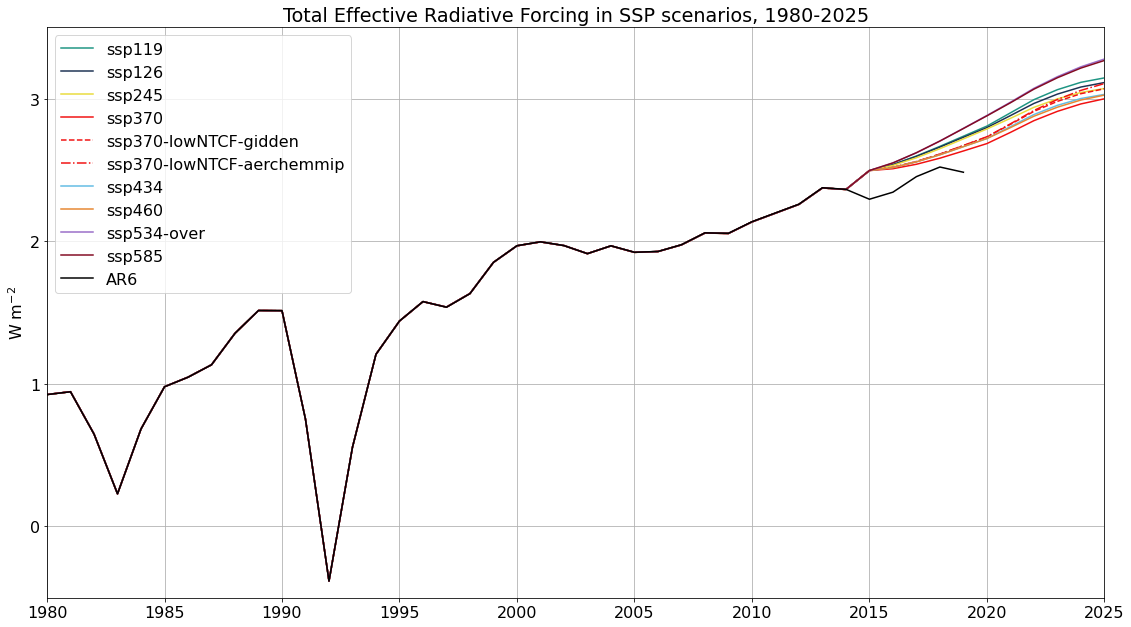

In [32]:
#pl.figure(figsize=(29.7/2.54,21/2.54))
pl.figure(figsize=(16,9))
for scenario in scenarios:
    pl.plot(np.arange(1980,2026), forcing[scenario]['total'][230:276], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.plot(np.arange(1980,2020), df_obs['total'].loc[1980:2020], color='k', label='AR6')
pl.yticks(np.arange(-4,14))
#pl.xticks(np.arange(1750,2501,50))
pl.ylim(-0.5,3.5)
pl.xlim(1980,2025)
pl.legend()
pl.grid()
pl.title('Total Effective Radiative Forcing in SSP scenarios, 1980-2025')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
pl.savefig('../plots/total_1980-2025.png')

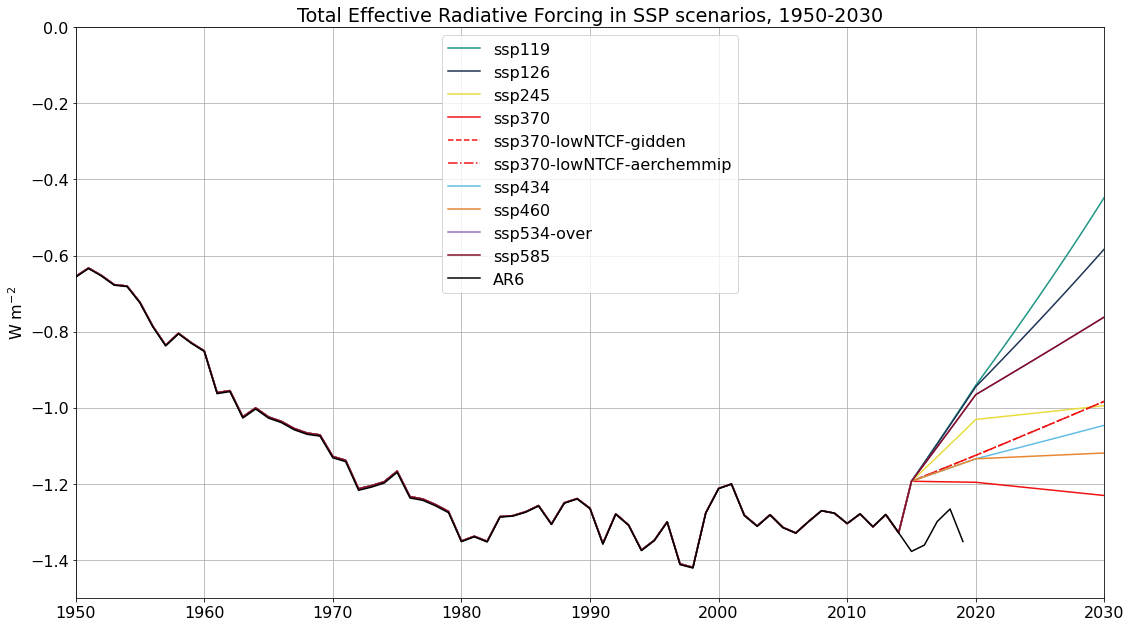

In [33]:
pl.figure(figsize=(16,9))
for scenario in scenarios:
    pl.plot(np.arange(1950,2031), forcing[scenario]['aerosol-radiation_interactions'][200:281]+forcing[scenario]['aerosol-cloud_interactions'][200:281], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.plot(np.arange(1950,2020), df_obs['aerosol-radiation_interactions'].loc[1950:2020]+df_obs['aerosol-cloud_interactions'].loc[1950:2020], color='k', label='AR6')
#pl.yticks(np.arange(-1.5,0.25))
#pl.xticks(np.arange(1750,2501,50))
pl.ylim(-1.5,0)
pl.xlim(1950,2030)
pl.legend()
pl.grid()
pl.title('Total Effective Radiative Forcing in SSP scenarios, 1950-2030')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('../plots/total_1980-2025.png')

In [36]:
f2x = meinshausen([2*ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], [ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], scale_F2x=False)[0]
scale_f2xco2 = 4.00/f2x
scale_f2xco2

1.0675196326121876

In [37]:
ghg_obs.loc[1750,'CO2']

278.7

In [38]:
etminan([2*ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], [ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], scale_F2x=False)[0]

3.802135696688914

In [39]:
meinshausen([2*ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], [ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], scale_F2x=False)[0]

3.7470036876156776